# COGS 118A- Project Checkpoint

# Names

- Caitlin Connolly
- Carolyn Yatco
- Abby Koornwinder
- Joshua Widjanarko
- Caike Campana

# Abstract 
Our project focuses on attempting to predict both a hotel's average score based on their reviews. We will be utilizing “515K Hotel Reviews Data in Europe” from Kaggle. This dataset contains 515,000 reviews from 1493 different hotels and contains the review which is seperated into the postive and negative comments within the review, the number word count of the positive and negative comments respectively, locations of hotel, days since the review. In addition, we will be doing sentiment analysis within the positive and negative comments to get the degree of the positivity and negativity. After the sentiment analysis we will be testing different models(OLS, K-Nearest Neighbor, etc) and determining which model has the highest accuracy. 


# Background
Beyond location, price, and amenities, consumers judge their perception on a possible hotel to stay out based on the experience “or reviews” of previous guests. For example, according to TripAdvisor, a site for hotel and restaurant reviews and booking, roughly 81% of people always or frequently check a hotel’s reviews before booking <a name="lorenz"></a>[<sup>[1]</sup>]. However, not all reviews and experiences are weighted equally. According to Sparks, B.A, and Browning, noticed that how information is framed within the review as well as the the focus of the review itself makes the biggest difference in how much a review would affect the overall view of a hotel  <a name="admonish"></a>[<sup>[2]</sup>]. This begs the question on whether a computer can take a look at these reviews and determine the trust(in the form of ratings) that a hotel has in a similar way to how humans prioritze certain ideas, information, and looking at the overall sentiments.. Sentiment analysis, the ability of extracting emotion, feeling, and other subjective states, has been used on a wide arrangement of different reviews from movies on Netflix to restaurant reviews <a name="sotanote"></a>[<sup>[3]</sup>]. However, most work on reviews ends with extracting the overall positivity or negativity of the review, not seeing if we can predict or gain insight on the overall view or rating of the hotel, movie, or other thing being reviewed. 


# Problem Statement

Our goal is to create a classifier for hotels in the European continent. We are going to use data from a review website its features, such as: Location; Negative and Positive reviews; user assigned tags; review age, and all the other features available. Thus, we combine the features into a classifier model and predict what will be the overall score of the hotel.

# Data

We are going to use the dataset [515K Hotel Reviews Data in Europe
](https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe) from the repository Kaggle and generated by the user Jianshen Liu. 

The dataset contains 515000 reviews of 1493 hotels throughout Europe, it was collected from the hotel booking website [booking](www.booking.com). It has 17 features, and some very useful are the average score, hotel name, geographical latitude,nationality of the  geographical longitude, days since the review, negative word counts, and positive word counts.

Each single observation contains one customer review with all the features. Despite the data being clean and with no missing values,we need to process the review text such that we have a quantifiable metric.



In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import datetime
import seaborn as sns

In [23]:

hotel = pd.read_csv("https://www.dropbox.com/s/58pkhlzvu3mlvg0/Hotel_Reviews.csv?dl=1")
hotel.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [24]:
hotel.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [25]:
hotel['Hotel_Address'].iloc[2000]

'1 2 Serjeant s Inn Fleet Street City of London London EC4Y 1LL United Kingdom'

In [26]:
hotel['Tags'].nunique

<bound method IndexOpsMixin.nunique of 0         [' Leisure trip ', ' Couple ', ' Duplex Double...
1         [' Leisure trip ', ' Couple ', ' Duplex Double...
2         [' Leisure trip ', ' Family with young childre...
3         [' Leisure trip ', ' Solo traveler ', ' Duplex...
4         [' Leisure trip ', ' Couple ', ' Suite ', ' St...
                                ...                        
515733    [' Leisure trip ', ' Family with older childre...
515734    [' Leisure trip ', ' Family with young childre...
515735    [' Leisure trip ', ' Family with older childre...
515736    [' Leisure trip ', ' Group ', ' Standard Tripl...
515737    [' Leisure trip ', ' Family with young childre...
Name: Tags, Length: 515738, dtype: object>

In [27]:
def tags_unique(lst) :
  lst = lst.split(',')

  return lst

dhotel = hotel['Tags']
final = []
for row in dhotel:
  row = row.replace('[', '')
  row = row.replace(']', '')
  row = row.replace("'", '')
  row = row.split(',')
  for i in range(len(row)):
    final.append(row[i])
final = set(final)

In [28]:
final

{'  Luxury Room Club Sofitel with Spa Access ',
 '  King Superior Room ',
 '  Premium Double or Twin Room with View ',
 '  Twin Executive Room ',
 '  Business Double Room ',
 '  Executive Room 1 Queen size Bed 1 Sofa Bed Balcony ',
 '  Signature Luxury King with Balcony ',
 '  Premier Deluxe Twin Room ',
 '  King Room with Executive lounge access ',
 '  Special Offer Deluxe Double Room ',
 '  Interconnecting Rooms ',
 '  Superior Deluxe Double or Twin Room with Spa Access ',
 '  Deluxe King Room with Canary Wharf View ',
 '  Junior Suite with City View ',
 '  Curve Suite with Lounge Access ',
 '  Deluxe One Bedroom Park Suite ',
 '  Executive King or Twin Room with Lounge Access ',
 ' Family with young children ',
 '  Two Adjacent Classic Double Rooms ',
 '  Triple Room with Spa Bath ',
 '  Superior Double Bedroom ',
 '  Premier Double Room ',
 '  Executive King Room with Lounge Access ',
 '  City Garden Room ',
 '  Executive Suite 1 King ',
 '  Delegate Deluxe Double Room ',
 '  Doubl

In [29]:
allwords=[]
words=list(final)

for a in range(len(words)):
  str=words[a]
  sentence=set(str.split(" ")) 
  for element in sentence:
    # add each element to the set
    allwords.append(element)

word_df=pd.DataFrame(allwords)

print(word_df.nunique()) 

print(word_df.value_counts())

0    731
dtype: int64
             2436
Room         1544
with          993
Double        780
Suite         548
             ... 
Oscar           1
Other           1
Oversized       1
PLAN            1
Nest            1
Length: 731, dtype: int64


<AxesSubplot:ylabel='0'>

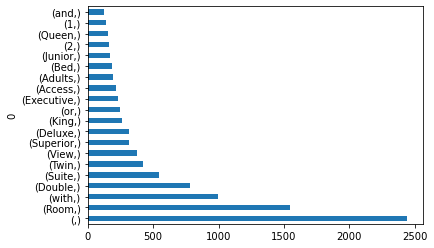

In [30]:
word_df.value_counts()[:20].plot(kind='barh')

## Lat/Long Country locator#

In [31]:
hotel['Hotel_Address'] = hotel['Hotel_Address'].str.strip()
hotel['Country'] = np.asarray(hotel['Hotel_Address'].str.split(' '))
hotel['Country'] = hotel['Country'].str[-1]
hotel.loc[hotel.Country == 'Kingdom','Country'] = 'United Kingdom'

In [32]:
hotel['days_since_review'] = hotel['days_since_review'].str.split(' ').str[0].astype(int)
hotel['Review_Date'] = pd.to_datetime(hotel['Review_Date'])

In [33]:
hotel['Country'].unique()

array(['Netherlands', 'United Kingdom', 'France', 'Spain', 'Italy',
       'Austria'], dtype=object)

In [34]:
hotel_countries = hotel.groupby(['Country']).agg({'Total_Number_of_Reviews': lambda x: sum(x), 'Reviewer_Score': lambda x: np.median(x), 'days_since_review': lambda x: np.mean(x) ,'Reviewer_Nationality': lambda x: list(set(x)), 'Hotel_Name': lambda x: len(list(set(x)))})
hotel_countries = hotel_countries.rename(columns={'Hotel_Name':'Number_Hotels', 'Reviewer_Score':'Median_Reviewer_Score', 'days_since_review':'Means_Days_Review'})
hotel_countries

,Total_Number_of_Reviews,Median_Reviewer_Score,Means_Days_Review,Reviewer_Nationality,Number_Hotels
Country,,,,,
Austria,90816216,8.8,363.396697,"[ Kuwait , Saudi Arabia , Montenegro , Liec...",158
France,76381850,8.8,360.960152,"[ Kuwait , Saudi Arabia , Montenegro , Liec...",458
Italy,129388482,8.8,347.507512,"[ Kuwait , Saudi Arabia , Montenegro , Liec...",162
Netherlands,195743618,8.8,342.067711,"[ Kuwait , Saudi Arabia , Montenegro , Mexi...",105
Spain,139005786,9.2,352.353771,"[ Kuwait , Saudi Arabia , Montenegro , Liec...",211
United Kingdom,783717062,8.8,355.784949,"[ Kuwait , Saudi Arabia , Montenegro , Liec...",400


## View

In [35]:
# Convert Review_Date into date time object 

hotel['Review_Date']= pd.to_datetime(hotel['Review_Date']) 
# hotel['Review_Date']

In [36]:
# Add a column to one-hot encode whether there is a view or not
# 1 --> there is a view
# 0 --> there is no view mentioned in the tags

view_count = 0
view = []
for i,tag in enumerate(dhotel): 
    #print (tag.dtype)
    if tag.find('view') != -1:
        view_count +=1
        view.append(1)
    elif tag.find('View') != -1:
        view_count+=1
        view.append(1)
    else:
        view.append(0)

print("The number of entries where a view is mentioned:", view_count)

# Add the one hot encoded column for View to the hotel dataframe
hotel['View'] = view

# Entries that have a view
hotel.loc[hotel['View'] == 1]


The number of entries where a view is mentioned: 18062


,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Country,View
5257,1 Addington Street Lambeth London SE1 7RY Unit...,1322,2017-08-03,8.4,Park Plaza County Hall London,United Kingdom,Extra bed was the worst breakfast queue was r...,44,6117,Just the location and view,6,1,5.0,"[' Leisure trip ', ' Family with young childre...",0,51.501400,-0.116009,United Kingdom,1
5263,1 Addington Street Lambeth London SE1 7RY Unit...,1322,2017-08-02,8.4,Park Plaza County Hall London,United Kingdom,Breakfast was an absolute disaster 20 minute ...,54,6117,Room was very well appointed and facilities w...,10,1,9.2,"[' Leisure trip ', ' Family with young childre...",1,51.501400,-0.116009,United Kingdom,1
5267,1 Addington Street Lambeth London SE1 7RY Unit...,1322,2017-07-31,8.4,Park Plaza County Hall London,Singapore,No Negative,0,6117,Location was great easy walk to London eye an...,57,6,10.0,"[' Leisure trip ', ' Family with young childre...",3,51.501400,-0.116009,United Kingdom,1
5271,1 Addington Street Lambeth London SE1 7RY Unit...,1322,2017-07-24,8.4,Park Plaza County Hall London,Turkey,No Negative,0,6117,It was a great stay for me and my family ever...,46,11,10.0,"[' Family with young children ', ' Executive S...",10,51.501400,-0.116009,United Kingdom,1
5275,1 Addington Street Lambeth London SE1 7RY Unit...,1322,2017-07-21,8.4,Park Plaza County Hall London,United States of America,Slow elevators lots of wait time Breakfast do...,19,6117,Great staff comfortable quiet rooms Breakfast...,11,2,8.8,"[' Leisure trip ', ' Family with young childre...",13,51.501400,-0.116009,United Kingdom,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515692,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,2016-07-05,8.1,Atlantis Hotel Vienna,Croatia,Parking in front of reception for guest check...,16,2823,Peace frendly staff nice breakfast location,7,9,9.2,"[' Business trip ', ' Solo traveler ', ' Super...",394,48.203745,16.335677,Austria,1
515706,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,2016-05-12,8.1,Atlantis Hotel Vienna,Hungary,No Negative,0,2823,Good location easy to park in the garage Vien...,21,27,8.8,"[' Leisure trip ', ' Group ', ' Superior Doubl...",448,48.203745,16.335677,Austria,1
515717,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,2016-01-03,8.1,Atlantis Hotel Vienna,Egypt,No Negative,0,2823,Good breakfast Shooping center with supermArk...,23,1,7.9,"[' Leisure trip ', ' Family with young childre...",578,48.203745,16.335677,Austria,1
515721,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,2015-12-08,8.1,Atlantis Hotel Vienna,Hungary,Smelly room door not closing properly too noisy,10,2823,Friendly staff comfortable bed good breakfast,8,3,6.7,"[' Leisure trip ', ' Solo traveler ', ' Superi...",604,48.203745,16.335677,Austria,1


# Regular vs Premium Room

In [37]:
hotel = hotel.assign(regular = np.zeros(hotel.shape[0]), deluxe = np.zeros(hotel.shape[0]))

In [38]:
def clean_tags(row):
    row = row.replace('[', '')
    row = row.replace(']', '')
    row = row.replace("'", '')
    row = row[1:-1]
    row = row.split(',')
    
    return row

hotel['Tags'] = hotel['Tags'].apply(clean_tags)

In [39]:
def deluxe(row):
    for deluxe in ['Deluxe', 'Premium', 'Superior', 'Prestige', 'Executive', 'Junior', 
                   'Penthouse', 'Privilege', 'Luxury', 'Sky', 'VIP', 'Fabulous', 
                   'Presidential', 'Grand']:
        if row['Tags'].__contains__(deluxe):
            return True

In [40]:
is_deluxe = []
for i in range(hotel.shape[0]):
    row = hotel.loc[i]['Tags']
    deluxe_yes = False
    for tag in row:
        for deluxe in ['Deluxe', 'Premium', 'Superior', 
                       'Prestige', 'Executive', 'Junior', 
                       'Penthouse', 'Privilege', 'Luxury',
                      'Sky', 'VIP', 'Fabulous', 'Presidential', 
                      'Grand']:
            if deluxe in tag:
                deluxe_yes = True
                break
        if deluxe_yes == True:
            break
    is_deluxe.append(deluxe_yes)

In [41]:
for count, boolean in enumerate(is_deluxe):
    if boolean:
        hotel.at[count, 'deluxe'] = 1
        hotel.at[count, 'regular'] = 0
    else:
        hotel.at[count, 'regular'] = 1
        hotel.at[count, 'deluxe'] = 0

## Group Size

In [42]:
# Add a column to keep track of the size of the party from the tags column 

hotel['Formatted_Tags'] = dhotel 
#hotel.loc[hotel['Formatted_Tags'] == 'Adults'] 

adults = []
children = []
total_guests = []
for i,tag in enumerate(dhotel):
    num_adults = 0
    num_children = 0
    num_guests = 0
    if tag.find('Adult') != -1:
        ind = tag.index('Adult')
        num_adults = tag[ind-2 : ind-1]
    if tag.find('Adults') != -1:
        ind = tag.index('Adults')
        num_adults = tag[ind-2 : ind-1]
    if tag.find('Child') != -1:
        ind = tag.index('Child')
        num_children = tag[ind-2 : ind-1]
    if tag.find('Children') != -1:
        ind = tag.index('Children')
        num_children = tag[ind-2 : ind-1]
    num_guests = int(num_adults) + int(num_children)
    adults.append(num_adults)
    children.append(num_children)
    total_guests.append(num_guests) 
    
hotel['Adults'] = adults
hotel['Children'] = children
hotel['Total_Guests'] = total_guests
    
print("The number of entries that note 1   or more guests:", hotel.loc[hotel['Total_Guests'] >= 1].size)

hotel.loc[hotel['Total_Guests'] >= 1]

The number of entries that note 1   or more guests: 270250


,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,...,lat,lng,Country,View,regular,deluxe,Formatted_Tags,Adults,Children,Total_Guests
5270,1 Addington Street Lambeth London SE1 7RY Unit...,1322,2017-07-25,8.4,Park Plaza County Hall London,Malaysia,the traffic near the hotel was madness but th...,29,6117,the location is the perks here it is walking ...,...,51.501400,-0.116009,United Kingdom,0,0.0,1.0,"[' Leisure trip ', ' Family with young childre...",3,0,3
5606,1 Addington Street Lambeth London SE1 7RY Unit...,1322,2017-01-13,8.4,Park Plaza County Hall London,Australia,Reception staff We paid in full upon arrival ...,78,6117,Location Laundry,...,51.501400,-0.116009,United Kingdom,0,0.0,1.0,"[' Leisure trip ', ' Family with young childre...",2,0,2
5630,1 Addington Street Lambeth London SE1 7RY Unit...,1322,2016-12-31,8.4,Park Plaza County Hall London,United Kingdom,No Negative,0,6117,Perfect location a few walking minutes away f...,...,51.501400,-0.116009,United Kingdom,0,0.0,1.0,"[' Leisure trip ', ' Solo traveler ', ' Junior...",2,0,2
5643,1 Addington Street Lambeth London SE1 7RY Unit...,1322,2016-12-25,8.4,Park Plaza County Hall London,Belgium,Dining room is too small for the amount of gu...,27,6117,Good clean and comfortable rooms Great location,...,51.501400,-0.116009,United Kingdom,0,0.0,1.0,"[' Leisure trip ', ' Couple ', ' Junior Suite ...",2,0,2
5724,1 Addington Street Lambeth London SE1 7RY Unit...,1322,2016-10-31,8.4,Park Plaza County Hall London,United States of America,I hated that the bathroom didn t have a real ...,81,6117,The staff was very accommodating and tried to...,...,51.501400,-0.116009,United Kingdom,0,0.0,1.0,"[' Leisure trip ', ' Couple ', ' Junior Suite ...",2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501292,Wagramer Stra e 8 22 Donaustadt 1220 Vienna Au...,117,2016-08-05,8.6,ARCOTEL Kaiserwasser Superior,Canada,Staff could be more friendly,7,1257,Suite Room was excellent nice six room though...,...,48.231915,16.417026,Austria,0,1.0,0.0,"[' Leisure trip ', ' Family with young childre...",2,2,4
501294,Wagramer Stra e 8 22 Donaustadt 1220 Vienna Au...,117,2016-08-02,8.6,ARCOTEL Kaiserwasser Superior,Germany,No thinking,3,1257,Excellent hotel,...,48.231915,16.417026,Austria,0,1.0,0.0,"[' Family with young children ', ' Family Room...",2,2,4
501297,Wagramer Stra e 8 22 Donaustadt 1220 Vienna Au...,117,2016-07-26,8.6,ARCOTEL Kaiserwasser Superior,Poland,No Negative,0,1257,Great place,...,48.231915,16.417026,Austria,0,1.0,0.0,"[' Leisure trip ', ' Family with young childre...",2,2,4
512453,Wildpretmarkt 5 01 Innere Stadt 1010 Vienna Au...,82,2015-09-27,8.9,Hotel Amadeus,Russia,Free wi fi was available in the room but all ...,28,717,The location was excellent just one minute fr...,...,48.210447,16.371578,Austria,0,1.0,0.0,"[' Business trip ', ' Solo traveler ', ' Busin...",1,0,1


## Tag Data and Hotel Size

In [43]:
tags=hotel["Tags"]
room_size_list=tags  
 
tag_size=[]
problematic_locations=[] # this is so i can look at the type of information tags are if they only have two
three=[]
four=[] 
five=[]
six=[]
problematic_tags=[]
for num in range(len(room_size_list)):
  a=room_size_list[num]
  tag_size.append(len(a))
  if (len(a)<=2):
    problematic_locations.append(num)
    problematic_tags.append(a)
  if(len(a)==6):
    six.append(a) 
  if(len(a)==5):
    five.append(a) 
  if(len(a)==4):
    four.append(a) 
  if(len(a)==3):
    three.append(a) 


print(tag_size.count(0))
print(tag_size.count(1))
print(tag_size.count(2)) 
print(tag_size.count(3)) 
print(tag_size.count(4)) 
print(tag_size.count(5)) 
print(tag_size.count(6))

0
6
85
5505
211564
297823
755


In [44]:
#getting room sizes 
bed_list=[]
for num in range(len(room_size_list)):
  temp_review=room_size_list[num]
  #all tags do not have the same amount of information as others. Some only have one or two tags. (The code looking at the tags is above) Fortunately the order is mostly the same 
  #thus based on the number of tags, we can the "room type" category
  
  length_tag=len(temp_review)
  if(length_tag==6): #tags with 6 allways follow the same pattern, with the fourth being the room tag
    temp_string=temp_review[3]
  elif(length_tag<=2):# all tags 2 or lower do not have the room type. There is code below that sets those with unknown rooms as 1 (for 1 bed)
    temp_string=temp_review[0]
  elif(length_tag==3): #though not all tags with 3 have the room, if it does, it is all located as the second value of the list 
    temp_string=temp_review[1]
  else:#those with 4 or 5 tag have the the room type as the third (the difference between 4 or 5 tags is the addition of mobile reviews for the fifth one)
    temp_string=temp_review[2]


  #before counting how many beds there are ( a rough estimate of size other than number of people), we need to do some cleaning to help clear some of the uneeded info
  temp_string=temp_string.lower()
  if ("children" in temp_string): 
    ind = temp_string.index('children')
    temp_string= temp_string.replace(temp_string[ind-2 : ind-1],"")
  elif("child" in temp_string ):  
    ind = temp_string.index('child')
    temp_string= temp_string.replace(temp_string[ind-2 : ind-1],"")

  if ("adults" in temp_string):
    ind = temp_string.index('adults')
    temp_string= temp_string.replace(temp_string[ind-2 : ind-1],"") 
  elif("adult" in temp_string):  
    ind = temp_string.index('adult')
    temp_string= temp_string.replace(temp_string[ind-2 : ind-1],"")

  if("people" in temp_string):
    ind = temp_string.index('people')
    temp_string= temp_string.replace(temp_string[ind-2 : ind-1],"")

  number_of_beds=0 
  #unfortunately, there is not one clear way to check how many beds there are based on a tag. Thus, we need to be able to extract some of the signifiers and use those to approximate the number of beds
 
  # Lets start with dealing with the word "and". By splitting the string, we can make it so that a room with a queen and a single can be counted as two beds rather than one 
  if("and" in temp_string):  
    temp_string=temp_string.split("and")
  else: 
    temp_string=[temp_string]

#unfortunately, the tags are less than standardized. Thus to count the number of beds, we need to have a hiearchy 
#from looking at the tags, numbers are used for two things: number of beds and people. As we have gotten rid of the numbers associated with people, 
# it will be the most trustworth way to find out how many beds 
# if that is not an option, we will use the hotel designations (double,triple etc. to discern it)
  for phrase in temp_string:
    if(phrase.isdigit()):
      num_list=[int(b) for b in phrase.split()]
      number_of_beds+= max(num_list)
    else:
      if ("quintuple" in phrase): 
        number_of_beds+=5
      elif("quadruple" in phrase): 
        number_of_beds+=4
      elif("triple" in phrase):
        number_of_beds+=3  
      elif("twin" in phrase):
        number_of_beds+=2
      elif("double" in phrase): 
        number_of_beds+=2
      elif(number_of_beds==0 and "family" in phrase):
        number_of_beds=2
      elif("single" in phrase):
        number_of_beds+=1
      else: 
        number_of_beds+=1

    if("extra" in phrase): 
      number_of_beds+=1  
    if("sofa" in phrase):
      if("with double sofa" in phrase): 
        number_of_beds+=2
      if("double sofa" in phrase == False):
        if("extra sofa" in phrase == False):
            number_of_beds+=1 

  bed_list.append(number_of_beds)

In [45]:
hotel["bed_list"]=bed_list

## EDA

Median and Median of Average Scores
8.397486902260287
8.4


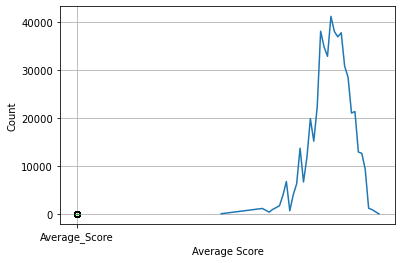

In [46]:
#plotting the average score for each hotel
avgscore_count = hotel.groupby(["Average_Score"]).agg(
    Count =pd.NamedAgg(column = "Average_Score",aggfunc="count")
)   
avg = sns.lineplot(x= "Average_Score", y = "Count", data = avgscore_count)
avg.set(xlabel = "Average Score")
hotel.boxplot(column=['Average_Score'])
avgm = hotel['Average_Score'].mean()
avgmed = hotel["Average_Score"].median()
print("Median and Median of Average Scores")
print(avgm)
print(avgmed)

Mean and Median For Positive Word Counts
17.77645820164502
11.0
Mean and Median For Negative Word Counts
18.539450263505888
9.0


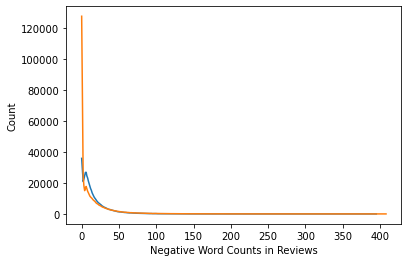

In [47]:
#countplots for positive and negative word counts in reviews
pos_word_count = hotel.groupby(["Review_Total_Positive_Word_Counts"]).agg(
    Count =pd.NamedAgg(column = "Review_Total_Positive_Word_Counts",aggfunc="count")
)   
pos =sns.lineplot(x= "Review_Total_Positive_Word_Counts", y = "Count", data = pos_word_count)
pos.set(xlabel = "Positive Word Counts in Reviews")

print("Mean and Median For Positive Word Counts")
pos_m = hotel['Review_Total_Positive_Word_Counts'].mean()
pos_med = hotel["Review_Total_Positive_Word_Counts"].median()
print(pos_m)
print(pos_med)

neg_word_count = hotel.groupby(["Review_Total_Negative_Word_Counts"]).agg(
    Count =pd.NamedAgg(column = "Review_Total_Negative_Word_Counts",aggfunc="count")
)   
neg = sns.lineplot(x= "Review_Total_Negative_Word_Counts", y = "Count", data = neg_word_count)
neg.set(xlabel = "Negative Word Counts in Reviews")

print("Mean and Median For Negative Word Counts")
neg_m = hotel['Review_Total_Negative_Word_Counts'].mean()
neg_med = hotel["Review_Total_Negative_Word_Counts"].median()
print(neg_m)
print(neg_med)


#note: there is a really big right tail on both graphs

0         0
1         0
2         0
3         0
4         0
         ..
515733    0
515734    0
515735    0
515736    0
515737    0
Name: Adults, Length: 515738, dtype: object
Mean and Median Adults:
0.04474170993799177
0.0
Mean and Median Children:
0.007001617100155505
0.0
Mean and Median of Total # of Guests
0.051743327038147276
0.0


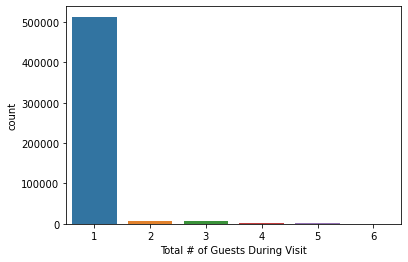

In [48]:
#countplots for adults, children, and total guests
sns.countplot( x = 'Adults', data = hotel)
print(hotel['Adults'])
hotel = hotel.astype({'Children':'int'})
sns.countplot(x = 'Children', data = hotel)
guests =sns.countplot(x="Total_Guests", data=hotel[-(hotel.Total_Guests == 0)])
guests.set(xlabel = "Total # of Guests During Visit")

print("Mean and Median Adults:")
ad_m = hotel['Adults'].astype(int).mean()
ad_med = hotel["Adults"].median()
print(ad_m)
print(ad_med)

print("Mean and Median Children:")
ch_m = hotel['Children'].mean()
ch_med = hotel["Children"].median()
print(ch_m)
print(ch_med)

#need to change so that the mean and median does not account for the 0 values
print("Mean and Median of Total # of Guests")
totalg_m = hotel['Total_Guests'].mean()
totalg_med = hotel["Total_Guests"].median()
print(totalg_m)
print(totalg_med)
#note: a huge number of 0s for each category - so can'

From our plots of the number of adult, children, and total guests, we can see that there are many 0 values for each category. As noted before, the total amount of reviews that list 1 or more guests is 248,630. Therefore, we can assume that the rest of the values had a 0 value mostly due to a lack of information. However, this also means that for the adult and chidren categories, we cannot make a firm conclusion on whether there were no adults or children, or whether the 0 value was due to missing information. On the other hand, we assume that there cannot be 0 total guests in a review since there must be at least one person to review the hotel. Therefore, we can get rid of the reviews that had a value of 0 when plotting the number of guests.

Most Common Country
0    United Kingdom
dtype: object


[Text(0, 0, 'Netherlands'),
 Text(1, 0, 'UK'),
 Text(2, 0, 'France'),
 Text(3, 0, 'Spain'),
 Text(4, 0, 'Italy'),
 Text(5, 0, 'Austria')]

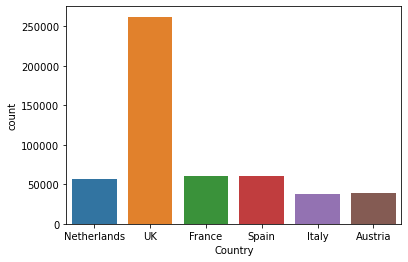

In [49]:
#country countplot
print("Most Common Country")
print(hotel['Country'].mode())
country = sns.countplot(x = 'Country', data = hotel)
country.set_xticklabels( ('Netherlands', 'UK', 'France',"Spain", "Italy", "Austria") )

[Text(0, 0, 'No View'), Text(1, 0, 'View')]

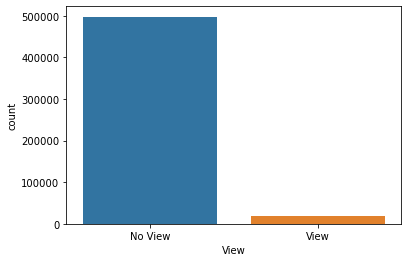

In [50]:
#view countplot
view = sns.countplot(x = "View", data = hotel)
view.set_xticklabels( ('No View', 'View') )
#note: a big ratio of no views:views

It can be assumed that there a large amount of no views because there were some reviews that did not mention if there was a view or not. Therefore, we cannot conclude that all of the "No Views" reviews did not actually have a review, because there is a possibility that the view was simply not stated in the person's review.

<BarContainer object of 6 artists>

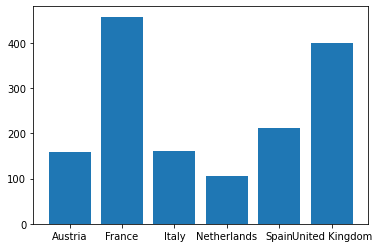

In [51]:
plt.bar(hotel_countries.index,hotel_countries['Number_Hotels'])

# Proposed Solution

Our proposed solution to predicting a hotel’s average score and an individual’s score of a hotel will have multiple parts: Preprocessing, data cleaning, sentiment analysis of written reviews, determining the best classifier for predicting scores, and finally, training, testing, and evaluation. <br>

To begin, here are the libraries we plan on using. <br>
import numpy as np<br>
import pandas as pd<br>
from nltk.corpus import stopwords<br>
from wordcloud import STOPWORDS<br>
import matplotlib.pyplot as plt<br>
import string<br>

To preprocess and clean our data we have to remove any entries with missing values as well as remove those that correspond to reviewers who did not write out reviews and instead only gave numerical scores. Since we plan on using sentiment analysis to classify the written reviews, we need to remove the entries that did not provide any additional information aside from a score. We then need to remove any columns that correspond to features we do not need. <br>
Thus, the variables we plan on using are: <br>
the review date<br>
the average hotel score<br>
hotel name<br>
reviewer nationality<br>
negative review <br>
positive review<br>
the number of reviews the reviewer has given in the past<br>
total number of valid reviews that the hotel has<br>
tags the reviewer has given the hotel. <br>


In order to perform sentiment analysis on the reviews we must perform some text cleaning. Namely, getting rid of stopwords, punctuation, and converting all letters to lowercase. We plan on performing a sentiment classification on the written reviews that will make the data quantitatively easier to put into our hotel rating prediction classifier. One way we can perform sentiment classification on the reviews is through using logistic regression to determine how positive or negative a review is. 

Next, we want to determine a classification model that would best predict the hotel ratings. The specific input we plan on using in this model are the nine variables listed above. Some potential models we could use include OLS and KNN. For instance, if we went with KNN we could use the ten closest neighbors and find the mean score of them.  We could also use a recurrent neural network (RNN) using Keras to perform sentiment analysis and classify the reviews.

To split our data into train and test sets, we will use 80% for training and 20% for testing, choosing what entry goes into which set randomly. Once we train our model we will test it, run our evaluation metrics, and plot our results using Matplotlib. 


# Evaluation Metrics

For our evaluation metrics, we have chosen to use the precision and recall scores to evaluate how many of our positive reviews are actually positive and how many of our negative reviews are actually negative. This will allow us to determine how good our model is at distinguishing positive from negative and therefore measure the accuracy of our model. 


To determine the errors we will use a confusion matrix to display the summary of our evaluations and calculate the errors made in our classification model. Through our confusion matrix, we will determine the sensitivity and specificity of our model, and our goal is to have high specificity and high sensitivity. As we tweak our model, we will compare the confusion matrices and re-train our model according to the results. 


A confusion matrix has two columns and two rows, where the columns are the true positive and negative conditions and the rows are the predicted positive and negative conditions. We have provided an example of what our confusion matrix might look like below.

![img1](images/ex_confusion_matrix)

For a confusion matrix we want to reduce the amount of errors our model makes and maximize our precision and recall scores while running our model on our testing data.

The precision score (true positive rate) is calculated at the amount of true positives divided by the total amount of positives (true positives and false positives). 

        Precision = true positives / (true positives + false positives)

The recall score (true negative rate) is calculated as the amount of true negatives divided by the total amount of negatives (true negatives and false negatives). 

        Recall = true negatives / (true negatives + false negatives)

The below table from Lecture 12 slides (subsequently taken from https://en.wikipedia.org/wiki/Precision_and_recall)[<sup>[4]</sup>] contains the mathematical representations from which the precision and recall are derived as well as contains other evaluation metrics which may prove useful as we begin to evaluate our model.

![img2](images/wiki_prec_recall_table)

# Preliminary results

NEW SECTION!

Please show any preliminary results you have managed to obtain.

Examples would include:
- Analyzing the suitability of a dataset or alogrithm for prediction/solving your problem 
- Performing feature selection or hand-designing features from the raw data. Describe the features available/created and/or show the code for selection/creation
- Showing the performance of a base model/hyper-parameter setting.  Solve the task with one "default" algorithm and characterize the performance level of that base model.
- Learning curves or validation curves for a particular model
- Tables/graphs showing the performance of different models/hyper-parameters



# Ethics & Privacy

Before beginning this project, our team has acknowledged potential ethics and privacy concerns that may arise from our data and implementation. Primarily, it is important to note that the dataset we plan on using is legally obtained as it is data from Booking.com that has been made publicly available. We discovered this specific collection of data from Kaggle.com, posted by Jiashen Liu who curated the dataset and made it available to the public domain to copy and modify as we intend to do. 
It is also important to acknowledge the potential biases in the dataset. Most notably, each data entry includes the nationality of the user which is one of the many various features provided by the dataset that we can use to predict the user’s score of the hotel. We take this into consideration as it can result in a potential bias in our predictions. 
Our team has also taken into consideration the privacy of the responders and has assured that the privacy of all reviewers is upheld as there are no identifying personal features other than the reviewer’s nationality. However, though there may be personal information in specific written reviews, all information was freely given by the individual. Thus, the anonymity of individuals is maintained. One way we can address these ethical and privacy concerns is through using an ethics checklist that addresses important ethical considerations in data collection, modeling, and analysis. A useful tool we can use to add such a checklist to our project is the command line tool, Deon. 


# Team Expectations 

Our team expectations strive to be in accordance with COGS 118A policies and guidelines. Each member has the responsibility to participate equally in all aspects of the project and communicate if any conflicts or difficulties arise. Meeting times will be planned in accordance with personal schedules and each member has a commitment to attend the meetings or make up any work if they are unable to attend. To keep things on a timely schedule each team member must be attentive to group conversations and keep in contact about any problems, ideas, or thoughts that could contribute to the project. In dividing any work among team members, each team member has the responsibility to contribute equally and finish their responsibilities at a timely manner. Additionally, each team member will be responsible for reviewing and communicating feedback as a whole before they are turned. If any conflicts arise, it is expected to be handled in a professional manner with consideration of all team members. Overall, it is expected that each team member will contribute equally and actively communicate to the rest of the team.


# Project Timeline Proposal


| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 4/21  |  7 PM |  Individual assigned for project proposal and write on shared document  | Review and turn in project proposal |
| 4/25 |  3 PM |  Consider general project information, possible questions, and variables | Discuss peer review assignment and divide parts | 
| 4/29  | 3PM | Finish individual peer review assignments  | General review of peer review assignment and turn in |
| 5/2  | 3PM |Consider specifics about the data and think about ideas to discuss with group; background research| Discuss how to clean data; assign work to do individually |
| 5/4 | 7 PM  | Continue assigned work for datasets, import and wrangle data | Discuss EDA methods; begin programming|
| 5/6  | 3 PM  | Assigned parts for EDA| Discuss next steps and possible features, algorithms, and metrics; look at EDA analysis and discuss |
| 5/9  |3 PM | Work on possible pilot results | Touch base with work and continuing pilot results  | 
|5/11|7 PM|Work on check point 1|Discuss individual work for checkpoint 1 and assign parts for peer review| 
|5/13|3 PM|Assigned coding for each member; work check point 1|Review all code written and make edits if needed, finalize and turn in check point 1|  
|5/20|7 PM|Finished assigned parts for peer reviews|Finalize and turn in checkpoint peer reviews| 
|5/24|3 PM|Work on coding and testing different possible models|Discuss models, finalize project solutions and assign programming;|
|5/27|3 PM|Refine coding and algorithms|Discuss final details and assign coding work to be done before next meeting| 
|6/1|7 PM|Work on assigned parts and be prepared to show teammates|Discuss collected work and divide work for end of project| 
|6/8|3 PM|Complete team eval survey separately|Overall review of final project, finalize, and turn in|

# Footnotes
<a name="lorenznote"></a>1.[^](#lorenz): Lorenz, T. (9 Dec 2021) Birds Aren’t Real, or Are They? Inside a Gen Z Conspiracy Theory. *The New York Times*. https://www.nytimes.com/2021/12/09/technology/birds-arent-real-gen-z-misinformation.html<br> 
<a name="admonishnote"></a>2.[^](#admonish): Also refs should be important to the background, not some randomly chosen vaguely related stuff. Include a web link if possible in refs as above.<br>
<a name="sotanote"></a>3.[^](#sota): Perhaps the current state of the art solution such as you see on [Papers with code](https://paperswithcode.com/sota). Or maybe not SOTA, but rather a standard textbook/Kaggle solution to this kind of problem
